In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from io import StringIO
from glob import glob
import wandb
import os
import molgrid
from argparse import Namespace
import torch
from scipy.stats import pearsonr
%matplotlib inline

In [2]:
pub_api = wandb.apis.public.Api()

In [3]:
def get_stats(epoch, pred_ddg, actual_ddg, pred_abs, actual_abs):
    try:
        r_ddg, _ = pearsonr(np.array(actual_ddg), np.array(pred_ddg))
    except ValueError as e:
        print('{}:{}'.format(epoch, e))
        r_ddg = np.nan
    try:
        r_abs, _ = pearsonr(np.array(pred_abs), np.array(actual_abs))
    except ValueError as e:
        print(f'{epoch}:{e}')
        r_abs = np.nan
    r = (r_ddg, r_abs)

    rmse_ddg = np.sqrt(((np.array(pred_ddg)-np.array(actual_ddg)) ** 2).mean())
    rmse_abs = np.sqrt(((np.array(pred_abs)-np.array(actual_abs)) ** 2).mean())
    rmse = (rmse_ddg, rmse_abs)

    mae = (np.abs(np.array(pred_ddg)-np.array(actual_ddg)).mean(),
            np.abs(np.array(pred_abs)-np.array(actual_abs)).mean())
    return r, rmse, mae

def get_eval(args,model_file):
    if args.use_model == "multtask_latent_def2018":
        from python_files.multtask_latent_def2018_model import Net
    elif args.use_model == "multtask_latent_dense":
        from python_files.multtask_latent_dense_model import Dense as Net
    test_data = molgrid.ExampleProvider(ligmolcache=f"cache/{args.ligte}", recmolcache=f"cache/{args.recte}", 
                                    shuffle=True, duplicate_first=True, default_batch_size=16,
                                    iteration_scheme=molgrid.IterationScheme.LargeEpoch)      
    test_data.populate(f"new_Prot_Lig_Valid/{args.testfile}")
    
    gmaker = molgrid.GridMaker(binary=args.binary_rep)      
    dims = gmaker.grid_dimensions(14*4)  # only one rec+onelig per example      
    tensor_shape = (16,)+dims      

    actual_dims = (dims[0]//2, *dims[1:])      
    model = Net(actual_dims,args).to('cuda')
    
    pretrained_state_dict = torch.load(model_file)      
    model_dict = model.state_dict()      
    pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}      
    model_dict.update(pretrained_dict)      
    model.load_state_dict(model_dict) 
    
    if "latent" in args.use_model:
        latent_rep = True
    else:
        latent_rep = False
        
    input_tensor_1 = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
    float_labels = torch.zeros(16, dtype=torch.float32)
    lig1_label = torch.zeros(16, dtype=torch.float32)
    lig2_label = torch.zeros(16, dtype=torch.float32)
    
    #running test loop
    model.eval()

    output_dist, actual = [], []
    lig_pred, lig_labels = [], []
    with torch.no_grad():
        for idx, batch in enumerate(test_data):        
            gmaker.forward(batch, input_tensor_1, random_translation=2.0, random_rotation=True) 
            batch.extract_label(1, float_labels)
            labels = torch.unsqueeze(float_labels, 1).float().to('cuda')
            batch.extract_label(2, lig1_label)
            batch.extract_label(3, lig2_label)
            lig1_labels = torch.unsqueeze(lig1_label, 1).float().to('cuda')
            lig2_labels = torch.unsqueeze(lig2_label, 1).float().to('cuda')
            if latent_rep:
                output, lig1, lig2, lig1_rep1, lig2_rep1 = model(input_tensor_1[:, :28, :, :, :], input_tensor_1[:, 28:, :, :, :])
#                 if proj:
#                     lig1_rep1 = proj(lig1_rep1)
#                     lig1_rep2 = proj(lig1_rep2)
#                     lig2_rep1 = proj(lig2_rep1)
#                     lig2_rep2 = proj(lig2_rep2)
            else:
                output, lig1, lig2 = model(input_tensor_1[:, :28, :, :, :], input_tensor_1[:, 28:, :, :, :])
            lig_pred += lig1.flatten().tolist() + lig2.flatten().tolist()
            lig_labels += lig1_labels.flatten().tolist() + lig2_labels.flatten().tolist()
            output_dist += output.flatten().tolist()
            actual += labels.flatten().tolist()
            
    r, rmse, mae = get_stats(0,output_dist,actual,lig_pred,lig_labels)
    return r, rmse, mae

In [4]:
their_data = """1 | 0.512 (0.434,0.593) | 1.18 (1.137,1.220)
2 | 0.604(0.589,0.620) |1.10(1.044,1.153)
3 | 0.624(0.617,0.632)|1.06(1.015,1.103)
4 | 0.602(0.520,0.684)|1.045(0.988,1.101)
5 | 0.623(0.614,0.636)|1.03(0.960,1.107)
6 | 0.636(0.628,0.647)|1.042(0.937,1.147)"""
their_data = their_data.replace(' ','').replace('|',',').replace('(',',').replace(')',',').replace(',,',',')
their_df = pd.read_csv(StringIO(their_data),sep=',',header=None)
their_df.columns = ['Addnl Ligs','R','R_stdl','R_stdg','RMSE','RMSE_stdl','RMSE_stdg','bad']
del their_df['bad']

In [5]:
their_df['R_std'] = (their_df['R']-their_df['R_stdl'])+(their_df['R_stdg']-their_df['R'])/2
their_df['RMSE_std'] = (their_df['RMSE']-their_df['RMSE_stdl'])+(their_df['RMSE_stdg']-their_df['RMSE'])/2

In [7]:
def create_stats(model_save_path,num_runs = 25,model="multtask_latent_def2018",
                 num_addnl=1,weight_decay=0,ddg_weight=10,consistency_weight=1,
                absolute_weight=1,rotation_weight=1):
    runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
                       filters={"$and":[{"config.use_model":model},{'tags':f'addnl_ligs_{num_addnl}'},
                                        {"config.rot_warmup":0},{"config.weight_decay":weight_decay},
                                        {"config.solver":"adam"},{"config.ddg_loss_weight":ddg_weight},
                                        {"config.consistency_loss_weight":consistency_weight},
                                        {"config.absolute_loss_weight":absolute_weight},
                                        {"config.rotation_loss_weight":rotation_weight},
                                        {"state":"finished"}]})
    assert len(runs) == num_runs, f"only have {len(runs)} runs"
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    rands = []
    stats_list = []
    for run in runs:
        rand = run.config['trainfile'].split('_')[-3]
        assert "rand" in rand, f"{randval}, doesn't have 'rand' in it"
        randval = int(rand.replace('rand',''))
        rands.append(randval)

        if not os.path.isfile(f"{model_save_path}model_{randval}.h5"):
            run.file('model.h5').download(root=model_save_path)
            os.rename(f"{model_save_path}model.h5",f"{model_save_path}model_{randval}.h5")

        config = Namespace()
        for k,v in run.config.items():
            setattr(config,k,v)

        r,rmse, mae = get_eval(config,f"{model_save_path}model_{randval}.h5")
#         print(r,rmse,mae)
        stats_list.append([randval,r[0],rmse[0],mae[0],r[1],rmse[1],mae[1]])
        break
        
        
    final_stats = pd.DataFrame(stats_list,columns=['randval','PearsonR','RMSE','MAE','Abs_PearsonR','Abs_RMSE','Abs_MAE'])
    final_stats.to_csv(f"{model_save_path}statistics.csv",index=False)
    
    return final_stats

In [8]:
create_stats('models/addnl_ligs/')

27648
27648


KeyboardInterrupt: 

In [4]:
# Pulling this data from W&B Report
my_data_list = [[1,0.5328,0.03314,1.134,0.0379],
               [2,0.6499,0.01873,0.9712,0.02487],
               [3,0.7026,0.01578,0.8981,0.02793],
               [4,0.734,0.01361,0.8504,0.02235],
               [5,0.758,0.01064,0.8127,0.01831],
               [6,0.7758,0.01302,0.7829,0.02375]]
my_df = pd.DataFrame(my_data_list,columns=['Addnl Ligs','R','R_std','RMSE','RMSE_std'])

In [5]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

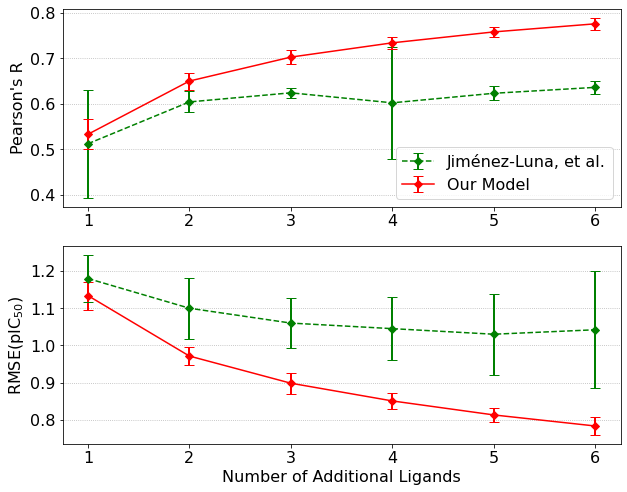

In [7]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.errorbar(their_df['Addnl Ligs'],their_df['R'],yerr=their_df['R_std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.errorbar(my_df['Addnl Ligs'],my_df['R'],yerr=my_df['R_std'],label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.ylabel("Pearson's R")
plt.legend()
ax = plt.gca()
ax.grid(axis='y',linestyle=':')
plt.subplot(212)
plt.errorbar(their_df['Addnl Ligs'],their_df['RMSE'],yerr=their_df['RMSE_std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.errorbar(my_df['Addnl Ligs'],my_df['RMSE'],yerr=my_df['RMSE_std'],label='ours',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.xlabel('Number of Additional Ligands')
plt.ylabel("RMSE(pIC$_{50}$)")
ax = plt.gca()
ax.grid(axis='y',linestyle=':')
plt.savefig('paper_comparison_both.png',dpi=500)

In [125]:
addnl_ligs_measures=['Test R','Test RMSE']
pub_api = wandb.apis.public.Api()
combined_data = pd.DataFrame(columns=[f'{val}_{stat}' for val in addnl_ligs_measures for stat in ['mean', 'std']])
def get_stats(runs,full_DF,idx_name):
    our_data = pd.DataFrame(columns=addnl_ligs_measures)
    for run in runs:
        new_row = pd.DataFrame.from_dict(run.history(keys=addnl_ligs_measures,pandas=False)[-1],orient='index').T
        our_data = our_data.append(new_row,ignore_index=True)
    final_data = pd.concat([our_data.mean(axis=0),our_data.std(axis=0)],axis=1)
    final_data.columns = ['mean','std']
    for idx, row in final_data.iterrows():
        if idx == '_step':
            continue
        for stat, data in row.items():
            full_DF.at[idx_name,f'{idx}_{stat}'] = data

In [126]:
runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
                   filters={"$and":[{"config.use_model":"multtask_latent_def2018"},{'tags':'addnl_ligs_1'},
                                    {"config.absolute_loss_weight":0},{"state":"finished"}]})
get_stats(runs,combined_data,'noDG')
runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
                   filters={"$and":[{"config.use_model":"def2018"},{'tags':'addnl_ligs_1'},
                                    {"state":"finished"},{"config.use_weights":None}]})
get_stats(runs,combined_data,'NoSiam')
# runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
#                    filters={"$and":[{"config.use_model":"multtask_latent_def2018"},{'tags':'addnl_ligs_1'},
#                                     {"state":"finished"},{"config.consistency_loss_weight":0}]})
# get_stats(runs,combined_data,'NoConsist')

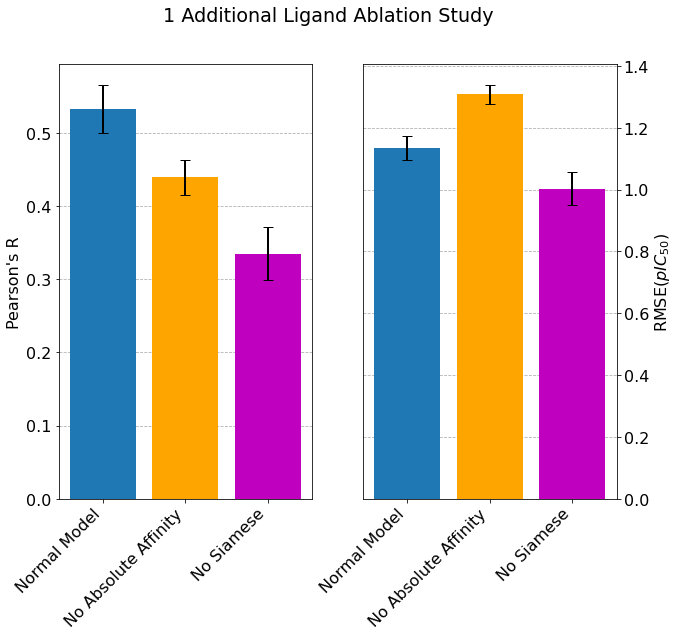

In [130]:
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.bar([2,3],combined_data['Test R_mean'],color=['orange','m'],tick_label=combined_data.index,yerr=combined_data['Test R_std'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
plt.bar(1,my_df['R'][0],tick_label='Normal Model',yerr=my_df['R_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Normal Model','No Absolute Affinity','No Siamese'],rotation=45,ha='right')
ax.set_ylabel("Pearson's R")
plt.subplot(122)
plt.bar([2,3],combined_data['Test RMSE_mean'],color=['orange','m'],tick_label=combined_data.index,yerr=combined_data['Test RMSE_std'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Normal Model','No Absolute Affinity','No Siamese'],rotation=45,ha='right')
ax.set_ylabel(r"RMSE($pIC_{50}$)")
plt.suptitle('1 Additional Ligand Ablation Study')
plt.savefig('/home/drew/Presentations/Retreat_2021/figs/mini_ablation_study.png',dpi=300,bbox_inches='tight')

In [94]:
combined_data

,Test R_mean,Test R_std,Test RMSE_mean,Test RMSE_std
noDG,0.439214,0.024134,1.30844,0.030873
NoSiam,0.335248,0.036261,1.003073,0.054447
NoConsist,0.510545,0.026297,1.176048,0.040046


In [112]:
paper_values = dict()
for filename in glob('external_test/*/Paper_*_R*.csv'):
    testset = filename.split('/')[1]
    measure = filename.split('_')[-1].split('.')[0]
    raw = pd.read_csv(filename,header=None)
    raw.columns = ['x','y']
    raw = raw.round({'x':0,'y':3})
    raw['x'] = raw['x'].abs()
    sorted_groupby = raw.sort_values(by=['x','y']).groupby('x')
    final = sorted_groupby.nth(1)
    final['std'] = (sorted_groupby.nth(2)-sorted_groupby.nth(0))/2
    if testset not in paper_values:
        paper_values[testset] = dict()
    paper_values[testset][measure] = final
paper_values.keys()

dict_keys(['BRD4', 'PTP1B', 'BACE', 'CDK2', 'JNK1', 'TYK2', 'MCL1', 'P38', 'Thrombin'])

In [114]:
external_dataset_measures=['Thrombin.Test RMSE','Thrombin.Test R','P38.Test RMSE','P38.Test R','BACE.Test RMSE',
                           'BACE.Test R','JNK1.Test RMSE','JNK1.Test R','PTP1B.Test RMSE','PTP1B.Test R',
                           'CDK2.Test RMSE','CDK2.Test R','BRD4.Test RMSE','BRD4.Test R','MCL1.Test RMSE',
                           'MCL1.Test R','TYK2.Test RMSE','TYK2.Test R']
runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
             filters={"$and":[{"config.use_model":'multtask_latent_def2018'},{'config.trainfile':'all_newdata.types'},
                             {"config.dropout":int(0)},{"config.stratify_rec":False},{"config.eval":True},{"state":"finished"}]})
our_data = pd.DataFrame(columns=external_dataset_measures)
for run in runs:
#     print(run)
    new_row = pd.DataFrame.from_dict(run.history(keys=external_dataset_measures,pandas=False)[0],orient='index').T
    our_data = our_data.append(new_row,ignore_index=True)

In [115]:
final_data = pd.concat([our_data.mean(axis=0),our_data.std(axis=0)],axis=1)
final_data.columns = ['mean','std']

In [116]:
import os.path 
def get_finetune(testset,finetune_fname='finetune'):
    values = dict()
    new_set = None
    fname = f'external_test/{testset}/{testset}_{finetune_fname}.txt'
    if not os.path.isfile(fname):
        return None
    with open(fname) as finet:
        for line in finet:
            if 'train' in line:
                if new_set:
                    values[addnl_ligs] = new_set
                addnl_ligs = line.split('_')[-1].split('.')[0]
            elif 'test' in line:
                aware = True
            elif 'DDG' in line and aware:
                new_set = line.strip().split(',')[1:-1]
                aware = False
    values[addnl_ligs] = new_set
    
    values_df = pd.DataFrame(values,dtype='float64').T
    values_df.columns=['Avg R','Stddev R','useless','Avg RMSE','Stddev RMSE']
    return values_df.sort_index()


In [122]:
import numpy as np
paper_values['TYK2']

{'RMSE':          y     std
 x                 
 1.0  1.545  0.2030
 2.0  1.502  0.1225
 3.0  1.432  0.0905
 4.0  1.358  0.0970
 5.0  1.357  0.1840
 6.0  1.254  0.2185,
 'R':          y     std
 x                 
 0.0  0.312  0.1465
 1.0  0.559  0.2035
 2.0  0.571  0.2330
 3.0  0.760  0.1410
 4.0  0.838  0.0675
 5.0  0.814  0.0895
 6.0  0.856  0.0750}

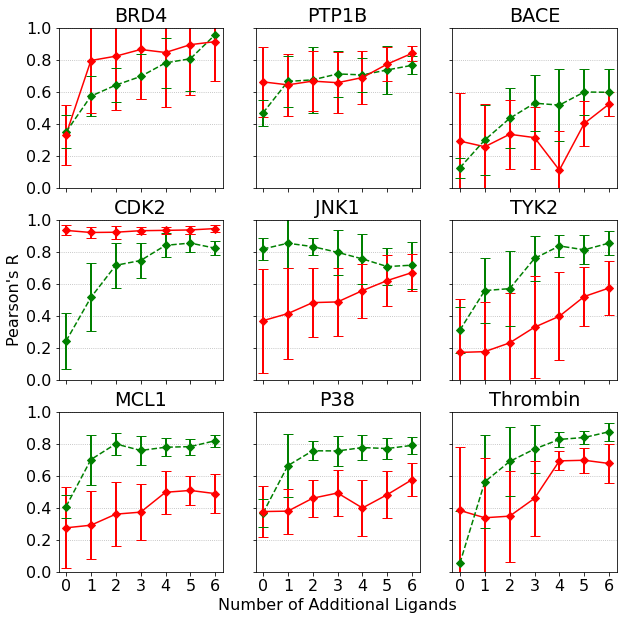

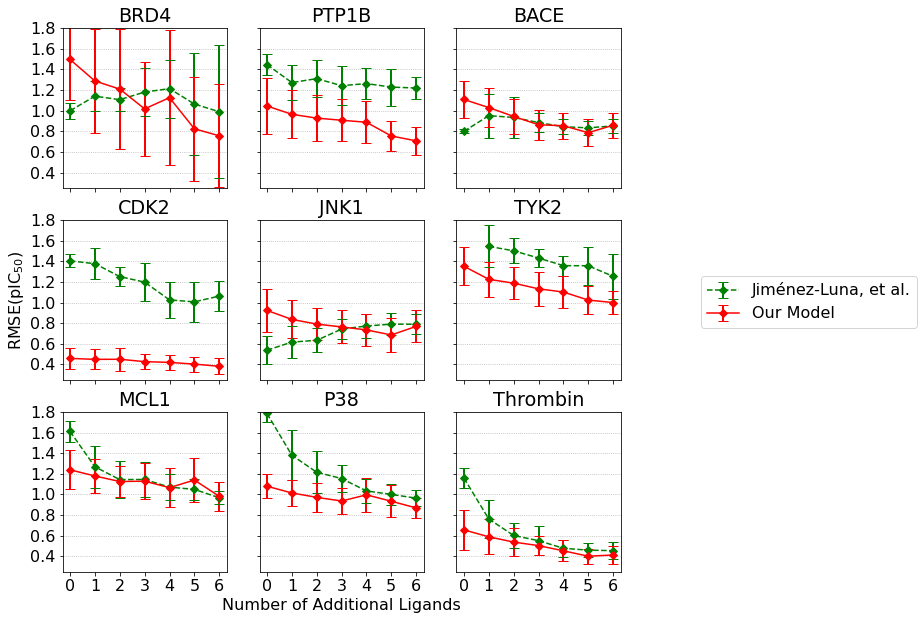

In [124]:
rfig, raxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
rmsefig, rmseaxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
for idx, test_set in enumerate(paper_values.keys()):
    val = [idx // 3, idx % 3]
    finetune_df = get_finetune(test_set)
    raxes[val[0],val[1]].set_title(test_set)
    theirs = raxes[val[0],val[1]].errorbar(paper_values[test_set]['R'].index,paper_values[test_set]['R']['y'],yerr=paper_values[test_set]['R']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    ours = raxes[val[0],val[1]].errorbar(0,final_data.loc[f'{test_set}.Test R','mean'],yerr=final_data.loc[f'{test_set}.Test R','std'],label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    if finetune_df is not None:
        raxes[val[0],val[1]].errorbar([int(val) for val in finetune_df.index.tolist()],finetune_df['Avg R'],yerr=finetune_df['Stddev R'],c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        raxes[val[0],val[1]].plot([0,1],[float(final_data.loc[f'{test_set}.Test R','mean']),float(finetune_df.loc['1','Avg R'])],c='r')
    if val[1] == 0 and val[0] == 1:
        raxes[val[0],val[1]].set_ylabel("Pearson's R")
    if val[0] == 2 and val[1] == 1:
        raxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
#     raxes[val[0],val[1]].legend()
#     ax = plt.gca()
    
    raxes[val[0],val[1]].set_ylim(bottom=0,top=1)
    raxes[val[0],val[1]].locator_params(axis='both',nbins=7)
    raxes[val[0],val[1]].grid(axis='y',linestyle=':')
#     if val[0] == 2 and val[1] == 2:
#         r_leg = rfig.legend([theirs,ours],['Jiménez-Luna, et al.','Our Model'],loc='center left',bbox_to_anchor=(1, 0.5))
    rmseaxes[val[0],val[1]].set_title(test_set)
    theirs= rmseaxes[val[0],val[1]].errorbar(paper_values[test_set]['RMSE'].index,paper_values[test_set]['RMSE']['y'],yerr=paper_values[test_set]['RMSE']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    ours = rmseaxes[val[0],val[1]].errorbar(0,final_data.loc[f'{test_set}.Test RMSE','mean'],yerr=final_data.loc[f'{test_set}.Test RMSE','std'],label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    if finetune_df is not None:
        rmseaxes[val[0],val[1]].errorbar([int(val) for val in finetune_df.index.tolist()],finetune_df['Avg RMSE'],yerr=finetune_df['Stddev RMSE'],c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        rmseaxes[val[0],val[1]].plot([0,1],[float(final_data.loc[f'{test_set}.Test RMSE','mean']),float(finetune_df.loc['1','Avg RMSE'])],c='r')
    if val[0] == 2 and val[1] == 1:
        rmseaxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
    if val[1] == 0 and val[0] == 1:
        rmseaxes[val[0],val[1]].set_ylabel("RMSE(pIC$_{50}$)")
    if val[0] == 2 and val[1] == 2:
        rmse_leg = rmsefig.legend([theirs,ours],['Jiménez-Luna, et al.','Our Model'],loc='center left',bbox_to_anchor=(1, 0.5))
    rmseaxes[val[0],val[1]].grid(axis='y',linestyle=':')
    rmseaxes[val[0],val[1]].set_ylim(bottom=0.25,top=1.8)
    rmseaxes[val[0],val[1]].locator_params(axis='both',nbins=8)
rfig.savefig('/home/drew/Presentations/Retreat_2021/figs/external_test_R.png',bbox_inches='tight',transparent=False)
rmsefig.savefig('/home/drew/Presentations/Retreat_2021/figs/external_test_RMSE.png',bbox_inches='tight',transparent=False)

In [17]:
def get_paper_compare(use_model,dropout,strat_rec,finetune_fname):
    if dropout == 0:
        dropout = int(dropout)
    runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
             filters={"$and":[{"config.use_model":use_model},{'config.trainfile':'all_newdata.types'},
                             {"config.dropout":dropout},{"config.stratify_rec":strat_rec},{"config.eval":True},{"state":"finished"}]})
    our_data = pd.DataFrame(columns=external_dataset_measures)
    for run in runs:
    #     print(run)
        new_row = pd.DataFrame.from_dict(run.history(keys=external_dataset_measures,pandas=False)[0][0],orient='index').T
        our_data = our_data.append(new_row,ignore_index=True)
    final_data = pd.concat([our_data.mean(axis=0),our_data.std(axis=0)],axis=1)
    final_data.columns = ['mean','std']
    rfig, raxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
    rmsefig, rmseaxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
    for idx, test_set in enumerate(paper_values.keys()):
        val = [idx // 3, idx % 3]
        finetune_df = get_finetune(test_set,finetune_fname)
        raxes[val[0],val[1]].set_title(test_set)
        theirs = raxes[val[0],val[1]].errorbar(paper_values[test_set]['R'].index,paper_values[test_set]['R']['y'],yerr=paper_values[test_set]['R']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        ours = raxes[val[0],val[1]].errorbar(0,final_data.loc[f'{test_set}.Test R','mean'],yerr=final_data.loc[f'{test_set}.Test R','std'],label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        if finetune_df is not None:
            raxes[val[0],val[1]].errorbar([int(val) for val in finetune_df.index.tolist()],finetune_df['Avg R'],yerr=finetune_df['Stddev R'],c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
            raxes[val[0],val[1]].plot([0,1],[float(final_data.loc[f'{test_set}.Test R','mean']),float(finetune_df.loc['1','Avg R'])],c='r')
        if val[1] == 0 and val[0] == 1:
            raxes[val[0],val[1]].set_ylabel("Pearson's R")
        if val[0] == 2 and val[1] == 1:
            raxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
    #     raxes[val[0],val[1]].legend()
    #     ax = plt.gca()

        raxes[val[0],val[1]].set_ylim(bottom=0,top=1)
        raxes[val[0],val[1]].locator_params(axis='both',nbins=7)
        raxes[val[0],val[1]].grid(axis='y',linestyle=':')
        if val[0] == 2 and val[1] == 2:
            r_leg = rfig.legend([theirs,ours],['Jiménez-Luna, et al.','Our Model'],loc='center left',bbox_to_anchor=(1, 0.5))
        
        rmseaxes[val[0],val[1]].set_title(test_set)
        theirs= rmseaxes[val[0],val[1]].errorbar(paper_values[test_set]['RMSE'].index,paper_values[test_set]['RMSE']['y'],yerr=paper_values[test_set]['RMSE']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        ours = rmseaxes[val[0],val[1]].errorbar(0,final_data.loc[f'{test_set}.Test RMSE','mean'],yerr=final_data.loc[f'{test_set}.Test RMSE','std'],label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        if finetune_df is not None:
            rmseaxes[val[0],val[1]].errorbar([int(val) for val in finetune_df.index.tolist()],finetune_df['Avg RMSE'],yerr=finetune_df['Stddev RMSE'],c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
            rmseaxes[val[0],val[1]].plot([0,1],[float(final_data.loc[f'{test_set}.Test RMSE','mean']),float(finetune_df.loc['1','Avg RMSE'])],c='r')
        if val[0] == 2 and val[1] == 1:
            rmseaxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
        if val[1] == 0 and val[0] == 1:
            rmseaxes[val[0],val[1]].set_ylabel("RMSE(pIC$_{50}$)")
        if val[0] == 2 and val[1] == 2:
            rmse_leg = rmsefig.legend([theirs,ours],['Jiménez-Luna, et al.','Our Model'],loc='center left',bbox_to_anchor=(1, 0.5))
        rmseaxes[val[0],val[1]].grid(axis='y',linestyle=':')
        rmseaxes[val[0],val[1]].set_ylim(bottom=0.25,top=1.8)
        rmseaxes[val[0],val[1]].locator_params(axis='both',nbins=8)
#     rfig.savefig('external_test/external_test_R.png',bbox_inches='tight',transparent=False)
#     rmsefig.savefig('external_test/external_test_RMSE.png',bbox_inches='tight',transparent=False)

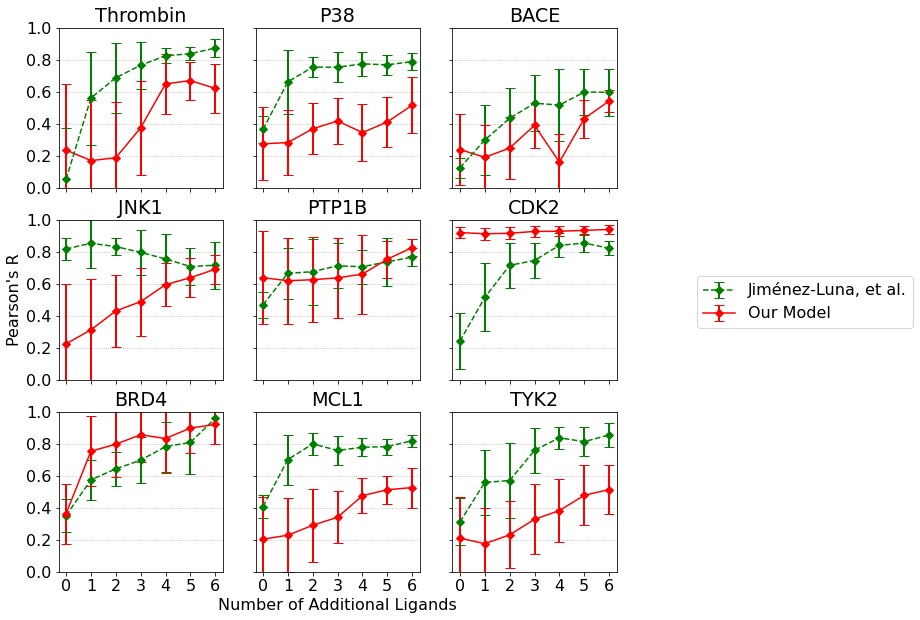

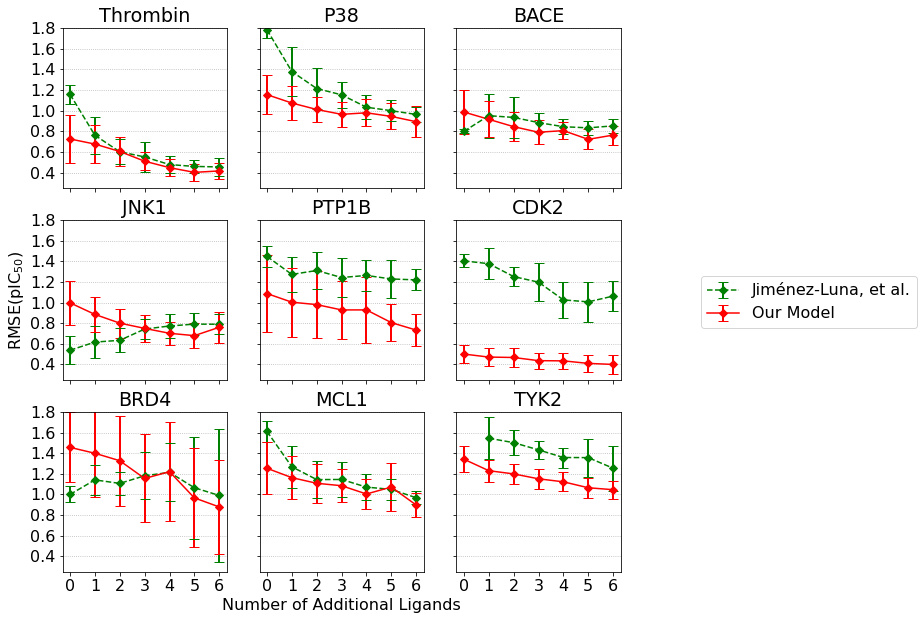

In [18]:
get_paper_compare('multtask_latent_def2018',0.5,False,'finetune_D5')

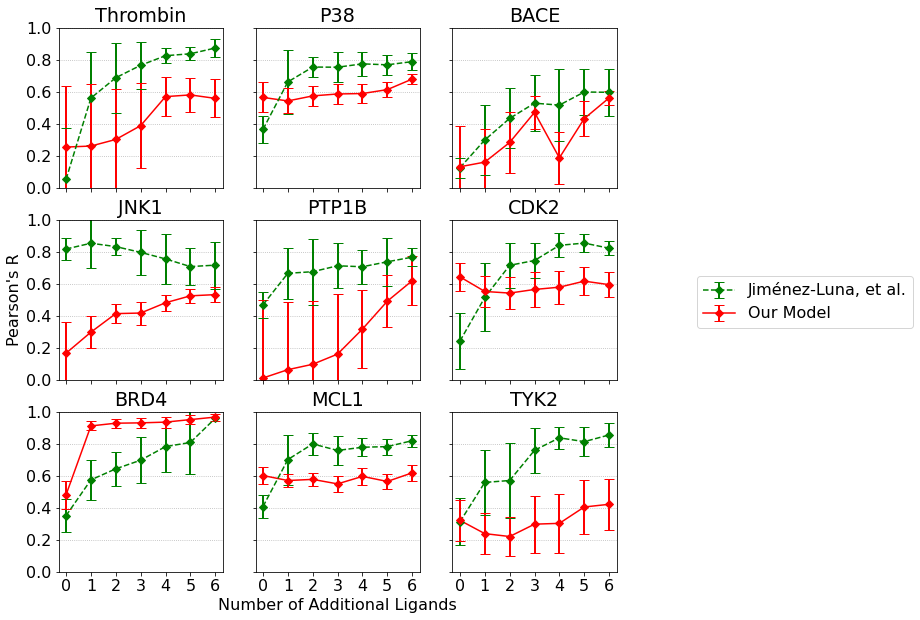

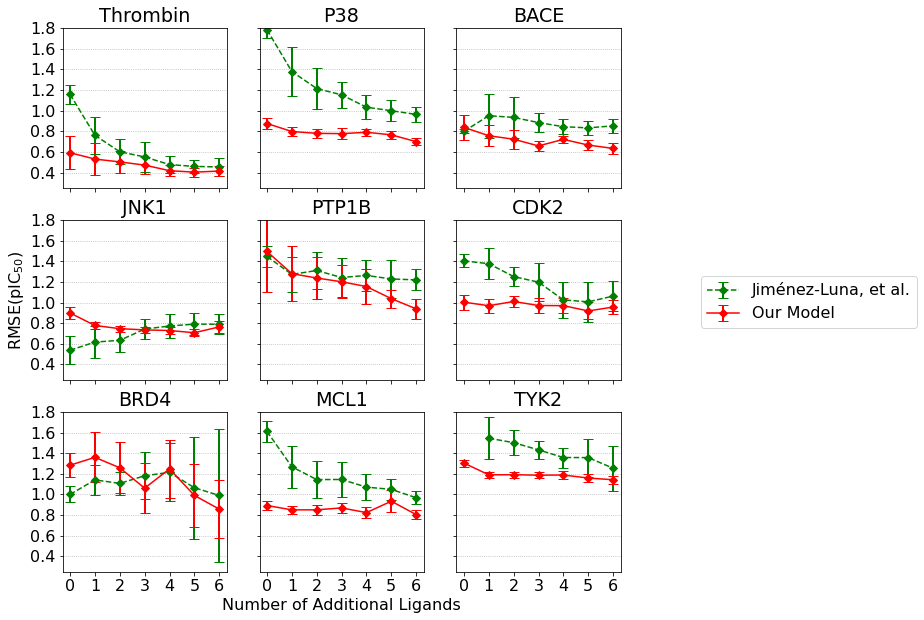

In [19]:
get_paper_compare('multtask_latent_def2018',0.5,True,'finetune_D5_SR')

/home/anm329/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


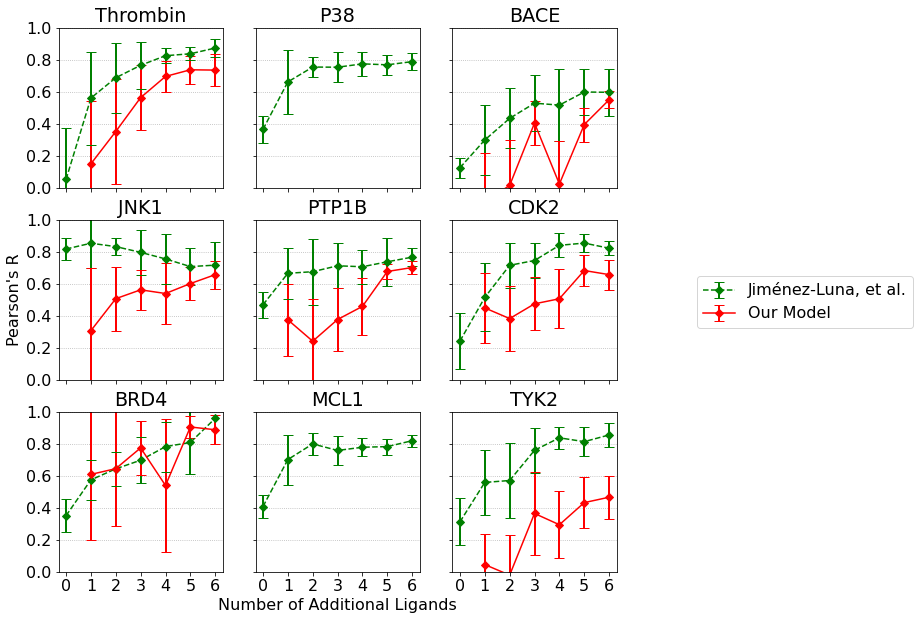

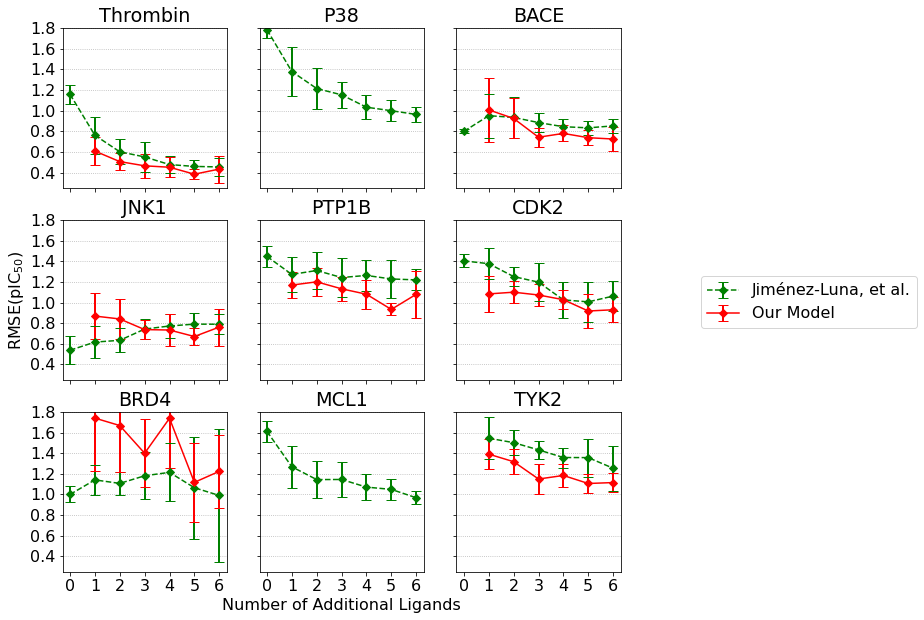

In [20]:
get_paper_compare('multtask_latent_def2018_concat',0,True,'finetune_concat_SR')